In [68]:
# --------------------
#  Purpose:
#        Using NaiveBayes to do text classification - MultinomialNB 
#  Modify History:
#        2018 - 12 - 20 
#  Proposer :
#        
#  python version: 3
# -------------------

#### 1.Modeling Import

In [69]:
#coding:utf-8
#python 3.x
import os 
import time 
import random
import jieba
import sklearn 
from sklearn.naive_bayes import MultinomialNB
import numpy as np 
import pylab as pl
import matplotlib.pyplot as plt

#### 2.出掉stopwords中的重复性的词语

In [70]:
def remove_deplicated_words(words):
    words_set = set()  # 利用set 的属性仅存储单一的元素
    with open(words,'r',encoding = 'utf-8') as readwords:
        for line in readwords.readlines():
            word  = line.strip()  # word is string 
            if len(word)>0 and word not in words_set: # 没有出现再现有的words 集合set 中则，增加进来
                words_set.add(word)
    return words_set

#### 2.1 读取变量的大小及类型

In [71]:
### 读取size 大小
import numpy as np
def GetInputSize(input):
    input   = list(input)
    inputs  = np.array(input)
    input_size = inputs.shape
    print("该变量的大小是 :",input_size)
    
def GetInputType(input):
    print("该变量类型是:",type(input))

#### 3.生成数据样本

In [84]:
def Examples_Generated(folder_path,test_dataset_percentage = 0.30):
    folder_list = os.listdir(folder_path)              # listdir - 用于列出该路劲下所有的文件及文件夹
    data_list   = []
    label_list  = []
    
    for folder in folder_list:
        new_folder_path = os.path.join(folder_path,folder)
        files           = os.listdir(new_folder_path)  # 读取每个文件夹下面的全部文件
        
        # Reading Files
        jindex =  1 # index initialization 
        for file in files:
            # worry about memory if >100:
            if jindex >= 100:
                print("文件数目大于100,读取停止!")
            
            # reading file from detail file path 
            with open(os.path.join(new_folder_path,file),'r') as open_handel:
                read_rawdata = open_handel.read()
            
            # jieba cut - 分词
            rawdata_cut      = jieba.cut(read_rawdata,cut_all = False)  # cut 精简model 
            rawdata_cut_list = list(rawdata_cut)
            
            data_list.append(rawdata_cut_list) # data 
            label_list.append(folder) # folder name is the label of the data in this folder
            # label_list.append(folder.decode('utf-8'))
            jindex += 1 
    
    # divide the dataset into train and test data manual 
    data_label_list = list(zip(data_list,label_list))# 将两个list以元祖的形式组合成list = [(data_list, label_list)]
    random.shuffle(data_label_list)  # 乱序
    
    # 手动区分 - Index_boundary 
    index_boundary = int(len(data_label_list)* test_dataset_percentage) 
    test_dataset   = data_label_list[0:index_boundary]
    train_dataset  = data_label_list[index_boundary: ]
    
    # 通过zip(*) 将原来组合的list 再重写解开成两个单独的list, one is data, other one is list 
    test_data,test_data_lable   = list(zip(*test_dataset))
    train_data,train_data_lable = list(zip(*train_dataset))
    
    # transform to list type
    train_data_lable = list(train_data_lable)
    test_data_lable  = list(test_data_lable)
    test_data  = list(test_data)
    train_data = list(train_data)
   
    # 统计词频方法all_words_dict 中
    statics_wordsfrequency_dict  = {}
    for word in train_data:     # every single 'word' in train_data 
        for character in word:  # every single 'character' in word
            if character in statics_wordsfrequency_dict:  # python3.x deleted has_key, has_key only used in python 2.x
                statics_wordsfrequency_dict[character] += 1   # dict[key] = value 赋值方法！
            else:
                statics_wordsfrequency_dict[character]  = 1

    # key = lambda x:x[1] - 按照每个元素的第二值即value 排序，reverse =True 逆序-降序排列
    order_statics_list = sorted(statics_wordsfrequency_dict.items(),key = lambda x:x[1], reverse =True) 
    all_words_list     = list(list(zip(*order_statics_list))[0]) # zip(*) 要转成list in python 3.x 
    
    # return 想要的结果
    return all_words_list, train_data, test_data, train_data_lable, test_data_lable  

#### 4.提取有价值的特征值

In [85]:
def feature_extraction (all_words_list,deletN, stopwords_set = set() ):
    # feature extraction 
    feature_words =  []
    n             =   1  
    for t in range(deletN,len(all_words_list),1):
        if not all_words_list[t].isdigit() and all_words_list[t] not in stopwords_set and 1< len(all_words_list[t])<5:
            feature_words.append(all_words_list[t])
    return feature_words

In [86]:
def text_features(train_data,test_data,feature_words,flag = 'nltk'):
    def text_features(text,feature_words):
        text_words = set(text)
        ##---------
        if flag   == 'nltk':
            features = {word: 1 if word in text_words else 0 for word in feature_words }
            
        elif flag == 'sklearn':
            features = [1 if word in text_words else 0 for word in feature_words]
        else:
            features = []
        ##---------
        return features
    
    train_feature_list  =  [text_features(text,feature_words) for text in train_data]
    test_feature_list   =  [text_features(text,feature_words) for text in test_data]
    return train_feature_list, test_feature_list

#### 5.模型训练

In [87]:
def text_model_classificaton(train_feature_list,test_feature_list,train_data_lable,test_data_lable,flag = 'nltk'):
    ## -----
    if flag == 'nltk':
        ## 使用nltk分类器
        train_list = zip(train_feature_list,train_data_lable)
        test_list  = zip(test_feature_list,test_data_lable)
        classifier = nltk.classify.NaiveBayesClassifier.train(train_list) # NaiveBayesClassifier  
        accuracy_test  = nltk.classify.accuracy(classifier,test_list)
    # -----
    elif flag == 'sklearn':
        classifier = MultinomialNB().fit(train_feature_list,train_data_lable)
        accuracy_test  = classifier.score(test_feature_list,test_data_lable)
    else:
        accuracy_test  = []
    return accuracy_test

Starting ... 
('\xe6\xb5\x8b\xe8\xaf\x95\xe5\x87\x86\xe7\xa1\xae\xe7\x8e\x87\xe6\x98\xaf:', [0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.7222222222222222, 0.7222222222222222, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.7222222222222222, 0.7222222222222222, 0.7222222222222222, 0.7777777777777778, 0.7777777777777778, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.8333333333333334, 0.83333

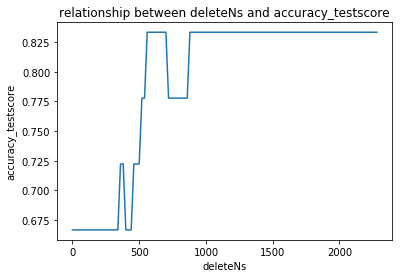

Completed!


In [88]:
print("Starting ... ")

# Text pre-processing 
folder_path = "./data/Database/SogouC/Sample"
all_words_list,train_data,test_data,train_data_lable,test_data_lable = Examples_Generated(folder_path,test_dataset_percentage = 0.20)

# Using sklearn to split dataset  
#rom sklearn.model_selection import train_test_split
#x_trian,x_test,y_train,y_test = train_test_split(train_data,test_data,random_state = 200)

# Generated stop words
stopwords_txtfile  = './data/stopwords_cn_in5NavBayesTextClassifier.txt'
stopwords_set      = remove_deplicated_words(stopwords_txtfile)

#all_words_list     = np.array(all_words_list) # 转成array - 
#print(type(all_words_list))
#all_words_reshaped = all_words_list.reshape(1,len(all_words_list))  # 转成1行，X列

# Get Variable Size 
#GetInputSize(all_words_list)
#GetInputSize(train_data)
#GetInputSize(train_data_lable)
#GetInputSize(test_data)
#GetInputSize(test_data_lable)

# Text Extraction and Classification 
flag      = 'sklearn'
deleteNs  = range(0,2300,20)
accuracy_testscore = []
for deleteN in deleteNs:
    feature_words      =   feature_extraction(all_words_list,deleteN,stopwords_set)
    train_feature_list, test_feature_list = text_features(train_data,test_data,feature_words,flag)
    accuracy_test      =  text_model_classificaton(train_feature_list,test_feature_list,train_data_lable,test_data_lable,flag)
    accuracy_testscore.append(accuracy_test)

print("测试准确率是:" , accuracy_testscore)

# Result 
plt.figure()
plt.plot(deleteNs,accuracy_testscore)
plt.title("relationship between deleteNs and accuracy_testscore")
plt.xlabel("deleteNs")
plt.ylabel("accuracy_testscore")
plt.show()

print("Completed!")